In [1]:
import uproot
import awkward as ak
import numpy as np
import sklearn.metrics as m
import boost_histogram as bh
import glob
import os
from scipy.interpolate import interp1d
import boost_histogram as bh

from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec

from cycler import cycler
# import mplhep as hep
# plt.style.use(hep.style.ROOT)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

def _p4_from_ptetaphie(pt, eta, phi, energy):
    import vector
    vector.register_awkward()
    return vector.zip({'pt': pt, 'eta': eta, 'phi': phi, 'energy': energy})
def _p4_from_ptetaphim(pt, eta, phi, mass):
    import vector
    vector.register_awkward()
    return vector.zip({'pt': pt, 'eta': eta, 'phi': phi, 'mass': mass})

from concurrent.futures import ThreadPoolExecutor
from functools import reduce
from operator import add

### Path

In [2]:
plot_dir = f"./28Feb"
import os
os.system(f"mkdir -p {plot_dir}")

0

## Boosted

In [3]:
# Categories
from types import SimpleNamespace
config = SimpleNamespace(
    categories = { # category name: (sample list, selection, label, color)
        "bkg_wjets": (["wjets"], "d.lep_pt > 0", r"Bkg: W+jets", "lightcyan"),
        "bkg_t_matched": (["ttbarsl", "wwsl", "twsl"], "~d.is_wcb & d.is_t_matched", r"Bkg ($t_{bqq'}$)", "blue"),
        "bkg_w_matched": (["ttbarsl", "wwsl", "twsl"], "~d.is_wcb & d.is_w_matched", r"Bkg ($W_{qq'}$)", "red"),
        "bkg_tbc_matched": (["ttbarsl", "wwsl", "twsl"], "~d.is_wcb & d.is_tbc_matched", r"Bkg ($t_{bc}$)", "orange"),
        "bkg_tbq_matched": (["ttbarsl", "wwsl", "twsl"], "~d.is_wcb & d.is_tbq_matched", r"Bkg ($t_{bq'}$)", "wheat"),
        "bkg_non_matched": (["ttbarsl", "wwsl", "twsl"], "~d.is_wcb & d.is_non_matched", r"Bkg (non)", "lightyellow"),

        # signals
        "sig_t_matched": (["ttbarsl_wcb", "wwsl_wcb", "twsl_wcb"], "d.is_wcb & d.is_t_matched", r"Sig ($t_{bqq'}$)", "blue"),
        "sig_w_matched": (["ttbarsl_wcb", "wwsl_wcb", "twsl_wcb"], "d.is_wcb & d.is_w_matched", r"Sig ($W_{qq'}$)", "red"),
        "sig_tbc_matched": (["ttbarsl_wcb", "wwsl_wcb", "twsl_wcb"], "d.is_wcb & d.is_tbc_matched", r"Sig ($t_{bc}$)", "orange"),
        "sig_tbq_matched": (["ttbarsl_wcb", "wwsl_wcb", "twsl_wcb"], "d.is_wcb & d.is_tbq_matched", r"Sig ($t_{bq'}$)", "wheat"),
        "sig_non_matched": (["ttbarsl_wcb", "wwsl_wcb", "twsl_wcb"], "d.is_wcb & d.is_non_matched", r"Sig (non)", "lightyellow"),
    },

    variables = {
        # for template making
        "sophon_discr2_dnn_hist2d": (("d.fj_sophon_discr2[:,0]", "d.score_is_w_matched"), (bh.axis.Regular(100, 0.9, 1), bh.axis.Regular(100, 0, 1))),
        "sophon_discr3_dnn_hist2d": (("d.fj_sophon_discr3[:,0]", "d.score_is_w_matched"), (bh.axis.Regular(100, 0.9, 1), bh.axis.Regular(100, 0, 1))),
    },

    signal_mul_factor = 10,

    categories_merged = {
        "bkg_wjets": ["bkg_wjets"],
        "bkg_allwhad_tbc": ["bkg_tbc_matched"],
        "bkg_allwhad_others": ["bkg_t_matched", "bkg_w_matched", "bkg_tbq_matched", "bkg_non_matched"],
        "sig": ["sig_t_matched", "sig_w_matched", "sig_tbc_matched", "sig_tbq_matched", "sig_non_matched"],
    }
)
# btag_wp = {"L": 0.0557, "M": 0.297, "T": 0.725}


In [4]:
import pickle
with open("pickles/wcb_ana_templ_2dhist_spdiscr2_newsample_v0216.pkl", "rb") as f:
    templs_summary = pickle.load(f)

In [14]:
import copy
import numpy as np

start, end = 100, 4000
log_start, log_end = np.log10(start), np.log10(end)
log_points = np.linspace(log_start, log_end, 20)
points = np.power(10, log_points)
observation_list = []


# aux_flavor_strength = 1
# sophon_discr_thres = 0.95; evt_dnn_thres = 0.87  # 0.951, 0.87 optimal for strength=1; 0.95, 0.86 optimal for strength=0.5


aux_flavor_strength = 0.5
sophon_discr_thres = 0.95; evt_dnn_thres = 0.86  # 0.951, 0.87 optimal for strength=1; 0.95, 0.86 optimal for strength=0.5

for i, point in enumerate(points):
    ## write templates
    print(f"No {i}, lumi: {point}")
    if aux_flavor_strength == 1 :
        filedir = f'/home/pku/zhaoyz/pheno/notebooks_v2/datacards/combined_updated/boosted/strength_1_no_{i}'
    elif aux_flavor_strength == 0.5 :
        filedir = f'/home/pku/zhaoyz/pheno/notebooks_v2/datacards/combined_updated/boosted/strength_0p5_no_{i}'
    else:
        raise ValueError("Invalid aux_flavor_strength")
    aux_weight_scale = point / 450 # for HL-LHC

    ########################################################
    _templs = copy.deepcopy(templs_summary) ## important!

    hist_out = {}
    # should first sum over the first Sophon discr index (start:end:bh.sum)
    for cm in config.categories_merged:
        hist_out[cm] = _templs["nom"][cm][int(sophon_discr_thres*1000)-900::bh.sum, :] ## important!

    for target_flv in ["bjet", "cjet", "ljet"]:
        for target_region in ["B1", "B2", "C1", "C2", "N"]:
            for target_variation in ["up", "down"]:
                _variation = "Up" if target_variation == "up" else "Down"
                # get the inclusive non-flavour-cut template's total yield
                nevt_tot_nom = sum(_templs["nom"][cm].view(flow=True).value.sum() for cm in config.categories_merged)
                nevt_tot_flv = sum(_templs[f"{target_flv}_{target_region}_{target_variation}"][cm].view(flow=True).value.sum() for cm in config.categories_merged)
                fac =  nevt_tot_nom / nevt_tot_flv

                for cm in config.categories_merged:
                    n = f"{cm}_ftag_{target_flv}_{target_region}{_variation}"
                    hist_out[n] = _templs[f"{target_flv}_{target_region}_{target_variation}"][cm][int(sophon_discr_thres*1000)-900::bh.sum, :] ## important!
                    # make sure the total yields doesn't change
                    hist_out[n].view().value *= fac
                    hist_out[n].view().variance *= fac**2
                    # hist_out[n].view().value *= sum(hist_out[cm].view().value) / sum(hist_out[n].view().value)
                    # hist_out[n].view().variance *= (sum(hist_out[cm].view().value) / sum(hist_out[n].view().value))**2

    hist_out['data_obs'] = sum(hist_out[cm] for cm in config.categories_merged)

    # aux weight scale
    for n in hist_out:
        hist_out[n].view().value *= aux_weight_scale
        hist_out[n].view().variance *= aux_weight_scale**2


    # rebin the DNN score
    # === old setup ===
    # for n in hist_out:
    #     # hist_out[n] = hist_out[n][bh.loc(0.96):bh.loc(1.0):bh.rebin(4)] # 1 bin from 0.96--1
    #     hist_out[n] = hist_out[n][bh.loc(0.6):bh.loc(1.0):bh.rebin(4)]
    #     hist_out[n].view().variance *= 0
    # ======
    def rebin_hist_var_width(orig_hist, new_axis):
        new_hist = bh.Histogram(new_axis, storage=bh.storage.Weight())
        for i in range(orig_hist.axes[0].size):
            bin_center = orig_hist.axes[0].centers[i]
            if bin_center > new_axis.edges[0] and bin_center < new_axis.edges[-1]:
                new_idx = np.searchsorted(new_axis.edges, bin_center) - 1
                new_hist.view().value[new_idx] += orig_hist.view().value[i]
                new_hist.view().variance[new_idx] += orig_hist.view().variance[i]
        return new_hist

    # write two templates: SR1 and SR2
    hist_out1, hist_out2 = {}, {}
    for n in hist_out:
        hist_out1[n] = rebin_hist_var_width(hist_out[n], bh.axis.Variable([evt_dnn_thres, 1.0])) # pass DNN bin
        hist_out1[n].view().value = np.maximum(hist_out1[n].view().value, 1e-3)
        hist_out1[n].view().variance *= 0

        hist_out2[n] = rebin_hist_var_width(hist_out[n], bh.axis.Variable([0, evt_dnn_thres])) # fail DNN bin
        hist_out2[n].view().value = np.maximum(hist_out2[n].view().value, 1e-3)
        hist_out2[n].view().variance *= 0

    import re
    for n in hist_out:
        if 'ftag' in n:
            hist_out1[n].view().value = hist_out1[n].view().value * aux_flavor_strength + hist_out1[re.sub(r"(_ftag_.*)", "", n)].view().value * (1 - aux_flavor_strength)
            hist_out2[n].view().value = hist_out2[n].view().value * aux_flavor_strength + hist_out2[re.sub(r"(_ftag_.*)", "", n)].view().value * (1 - aux_flavor_strength)

    print('Apply aux weight scale:', aux_weight_scale)
    print(hist_out1['data_obs'].values().sum(), hist_out2['data_obs'].values().sum())

    with uproot.recreate(f'{filedir}/input_SR1.root') as fw:
        for n in hist_out1:
            fw[n] = hist_out1[n]
    with uproot.recreate(f'{filedir}/input_SR2.root') as fw:
        for n in hist_out2:
            fw[n] = hist_out2[n]

    lines = open(f'/home/pku/zhaoyz/pheno/notebooks_v2/datacards/combined_updated/boosted/datacards_templ.txt').readlines()
    for i, line in enumerate(lines):
        if line.startswith('observation'):
            lines[i] = f'observation {hist_out1["data_obs"].values().sum()} {hist_out2["data_obs"].values().sum()}\n'
    with open(f'{filedir}/datacard.txt', 'w') as f:
        f.writelines(lines)

No 0, lumi: 100.0
Apply aux weight scale: 0.2222222222222222
31.671146070558716 6070.810533038166
No 1, lumi: 121.42802934538574
Apply aux weight scale: 0.2698400652119683
38.45764854457802 7371.665595560351
No 2, lumi: 147.44766310703878
Apply aux weight scale: 0.3276614735711973
46.698364760255565 8951.268262620742
No 3, lumi: 179.04279162670053
Apply aux weight scale: 0.39787287028155677
56.70490406489841 10869.348652719314
No 4, lumi: 217.408133557268
Apply aux weight scale: 0.48312918568281776
68.85564754819772 13198.435871676309
No 5, lumi: 263.9944122151748
Apply aux weight scale: 0.5866542493670551
83.61005591078091 16026.600583391026
No 6, lumi: 320.56321233482146
Apply aux weight scale: 0.7123626940773811
101.52604322703661 19460.78525946784
No 7, lumi: 389.25359154443817
Apply aux weight scale: 0.8650079812098626
123.281073562935 23630.84803570912
No 8, lumi: 472.66296536854884
Apply aux weight scale: 1.050362145263442
149.6977781833075 28694.47308736441
No 9, lumi: 573.9453

# Resolved

In [5]:
# Categories
from types import SimpleNamespace
config = SimpleNamespace(
    categories = { # category name: (sample list, selection, label, color)
        "bkg_wjets": (["wjets"], "d.lep_pt > 0", r"Bkg: W+jets", "lightcyan"),
        "bkg_ttbarsl": (["ttbarsl"], "~d.is_wcb", r"Bkg ($t\overline{t}$)", "orange"),
        "bkg_twsl": (["twsl"], "~d.is_wcb", r"Bkg ($tW$)", "magenta"),
        "bkg_wwsl": (["wwsl"], "~d.is_wcb", r"Bkg (WW)", "green"),

        "sig_ttbarsl": (["ttbarsl_wcb"], "d.is_wcb", r"Sig ($t\overline{t}$)", "orange"),
        "sig_twsl": (["twsl_wcb"], "d.is_wcb", r"Sig ($tW$)", "magenta"),
        "sig_wwsl": (["wwsl_wcb"], "d.is_wcb", r"Sig (WW)", "green"),
    },

    variables = {
        "evt_dnn_score_0p9_1_1000": ("d.evt_dnn_score", bh.axis.Regular(1000, 0.9, 1)), # to make templates
    },

    signal_mul_factor = 10,

    categories_merged = {
        "bkg_wjets": ["bkg_wjets"],
        "bkg_allwhad": ["bkg_ttbarsl", "bkg_twsl", "bkg_wwsl"],
        "sig": ["sig_ttbarsl", "sig_twsl", "sig_wwsl"],
    },
)
# btag_wp = {"L": 0.0557, "M": 0.297, "T": 0.725}


In [6]:
import pickle

with open("pickles/wcb_rsvana_templ_newsample_v0216_nbc3.pkl", "rb") as f:
    templs_summary = pickle.load(f)
# to exclude fatjet phase space from resolved channel, use this one
# with open("pickles/wcb_rsvana_templ_newsample_v0216_nbc3_excludefj.pkl", "rb") as f:
#     templs_summary = pickle.load(f)

with open("pickles/wcb_rsvana_templ_newsample_v0216.pkl", "rb") as f:
    templs_summary_orig = pickle.load(f)

In [8]:
def convert_decimal_to_string(decimal_number):
    # 将小数转换为字符串
    str_number = str(decimal_number)
    
    # 去掉小数点
    str_number = str_number.replace('.', '')
    
    # 在适当位置插入字母 'p'
    # 假设整数部分为1位，小数部分为2位
    converted_string = str_number[0] + 'p' + str_number[1:]
    
    return converted_string

In [20]:
for idx, i in enumerate(list(np.arange(0.5,0.99,0.02))):
    print(round(i, 2))
    j = round(i, 2)
    thres_str = convert_decimal_to_string(j)
    # filedir = f'./datacards/new_senario/resolved/strength_point_{point_idx}_{thres_str}'
    os.system(f"mv ./datacards/new_senario/resolved/strength_point_39_{thres_str} ./datacards/new_senario/resolved/strength_point_39_{idx}")

0.5
0.52
0.54
0.56
0.58
0.6
0.62
0.64
0.66
0.68
0.7
0.72
0.74
0.76
0.78
0.8
0.82
0.84
0.86
0.88
0.9
0.92
0.94
0.96
0.98


In [22]:
for idx, i in enumerate(list(np.arange(0.5,0.99,0.02))):
    print(idx, round(i,2))

0 0.5
1 0.52
2 0.54
3 0.56
4 0.58
5 0.6
6 0.62
7 0.64
8 0.66
9 0.68
10 0.7
11 0.72
12 0.74
13 0.76
14 0.78
15 0.8
16 0.82
17 0.84
18 0.86
19 0.88
20 0.9
21 0.92
22 0.94
23 0.96
24 0.98


In [25]:
np.sqrt(450/140)

1.7928429140015905

In [33]:
for idx, i in enumerate(list(np.arange(0.96,1,0.002))):
    print(idx, round(i,4))

0 0.95
1 0.954
2 0.958
3 0.962
4 0.966
5 0.97
6 0.974
7 0.978
8 0.982
9 0.986
10 0.99
11 0.994
12 0.998


In [38]:
for thres_idx, thres in enumerate(list(np.arange(0.95,0.998,0.002))):
    thres = round(thres, 6)
    print(thres)

0.95
0.952
0.954
0.956
0.958
0.96
0.962
0.964
0.966
0.968
0.97
0.972
0.974
0.976
0.978
0.98
0.982
0.984
0.986
0.988
0.99
0.992
0.994
0.996
0.998


In [39]:
import copy
import numpy as np

start, end = 100, 4000
log_start, log_end = np.log10(start), np.log10(end)
log_points = np.linspace(log_start, log_end, 20)
points = np.power(10, log_points)
observation_list = []
    
# aux_flavor_strength = 1
# evt_dnn_thres = 0.990  


# aux_flavor_strength = 0.5
# evt_dnn_thres = 0.986  

# points = [450]
for point_idx, point in enumerate(points):
    
    ## new impl. for templs adding a flavour tagger cut

    ## write templates
    print(f"No {point_idx}, lumi: {point}")
    
    
    aux_flavor_strength = 1/np.sqrt(point/140) 
    aux_weight_scale = point / 450 # for HL-LHC

    for thres_idx, thres in enumerate(list(np.arange(0.95,0.998,0.002))):
        thres = round(thres, 6)
        print(f"lumi:{point},thres:{thres}")
        evt_dnn_thres = thres
        thres_str = convert_decimal_to_string(evt_dnn_thres)
        filedir = f'./datacards/new_senario/resolved/strength_point_{point_idx}_{thres_idx}'
        os.system(f"mkdir -p {filedir}")
        # evt_dnn_thres = 0.990  # 0.990-0.992 all optimal..; for stregth=0.5, 0.986; for stregth=0.2, 0.983

        ########################################################
        import copy
        _templs = copy.deepcopy(templs_summary) ## important!
        _templs0 = copy.deepcopy(templs_summary_orig) ## important!

        hist_out = {}
        for cm in config.categories_merged:
            hist_out[cm] = _templs["nom"][cm]

        for target_flv in ["bjet", "cjet", "ljet"]:
            for target_region in ["B1", "B2", "C1", "C2", "N"]:
                for target_variation in ["up", "down"]:
                    _variation = "Up" if target_variation == "up" else "Down"
                    # get the inclusive non-flavour-cut template's total yield
                    nevt_tot_nom = sum(_templs0["nom"][cm].view(flow=True).value.sum() for cm in config.categories_merged)
                    nevt_tot_flv = sum(_templs0[f"{target_flv}_{target_region}_{target_variation}"][cm].view(flow=True).value.sum() for cm in config.categories_merged)
                    fac =  nevt_tot_nom / nevt_tot_flv

                    for cm in config.categories_merged:
                        n = f"{cm}_ftag_{target_flv}_{target_region}{_variation}"
                        hist_out[n] = _templs[f"{target_flv}_{target_region}_{target_variation}"][cm]
                        # make sure the total yields doesn't change (use non-flavour-cut template)
                        hist_out[n].view().value *= fac
                        hist_out[n].view().variance *= fac**2

        hist_out['data_obs'] = sum(hist_out[cm] for cm in config.categories_merged)

        # aux weight scale
        for n in hist_out:
            hist_out[n].view().value *= aux_weight_scale
            hist_out[n].view().variance *= aux_weight_scale**2


        def rebin_hist_var_width(orig_hist, new_axis):
            new_hist = bh.Histogram(new_axis, storage=bh.storage.Weight())
            for i in range(orig_hist.axes[0].size):
                bin_center = orig_hist.axes[0].centers[i]
                if bin_center > new_axis.edges[0] and bin_center < new_axis.edges[-1]:
                    new_idx = np.searchsorted(new_axis.edges, bin_center) - 1
                    new_hist.view().value[new_idx] += orig_hist.view().value[i]
                    new_hist.view().variance[new_idx] += orig_hist.view().variance[i]
            return new_hist

        for n in hist_out:
            hist_out[n] = rebin_hist_var_width(hist_out[n], bh.axis.Variable([evt_dnn_thres, 1]))
            hist_out[n].view().value = np.maximum(hist_out[n].view().value, 1e-3)
            hist_out[n].view().variance *= 0

        import re
        for n in hist_out:
            if 'ftag' in n:
                hist_out[n].view().value = hist_out[n].view().value * aux_flavor_strength + hist_out[re.sub(r"(_ftag_.*)", "", n)].view().value * (1 - aux_flavor_strength)

        print('Apply aux weight scale:', aux_weight_scale)
        print(hist_out['data_obs'].values().sum())

        with uproot.recreate(f'{filedir}/input_SR.root') as fw:
            for n in hist_out:
                fw[n] = hist_out[n]

        lines = open(f'/home/pku/zhaoyz/pheno/notebooks_v2/datacards/new_senario/resolved/datacards_templ.txt').readlines()
        for i, line in enumerate(lines):
            if line.startswith('observation'):
                lines[i] = f'observation {hist_out["data_obs"].values().sum()}\n'
        with open(f'{filedir}/datacard.txt', 'w') as f:
            f.writelines(lines)

No 39, lumi: 100.0
lumi:100.0,thres:0.95
Apply aux weight scale: 0.2222222222222222
2954.210225340696
lumi:100.0,thres:0.952
Apply aux weight scale: 0.2222222222222222
2711.259681381141
lumi:100.0,thres:0.954
Apply aux weight scale: 0.2222222222222222
2494.7285404809268
lumi:100.0,thres:0.956
Apply aux weight scale: 0.2222222222222222
2285.920587128651
lumi:100.0,thres:0.958
Apply aux weight scale: 0.2222222222222222
2064.189184940709
lumi:100.0,thres:0.96
Apply aux weight scale: 0.2222222222222222
1879.0567081084216
lumi:100.0,thres:0.962
Apply aux weight scale: 0.2222222222222222
1671.896426250436
lumi:100.0,thres:0.964
Apply aux weight scale: 0.2222222222222222
1490.2619182822202
lumi:100.0,thres:0.966
Apply aux weight scale: 0.2222222222222222
1311.6621302667818
lumi:100.0,thres:0.968
Apply aux weight scale: 0.2222222222222222
1158.7707069527148
lumi:100.0,thres:0.97
Apply aux weight scale: 0.2222222222222222
987.1454922902591
lumi:100.0,thres:0.972
Apply aux weight scale: 0.222222

### Make the plots

Done boosted strength 1


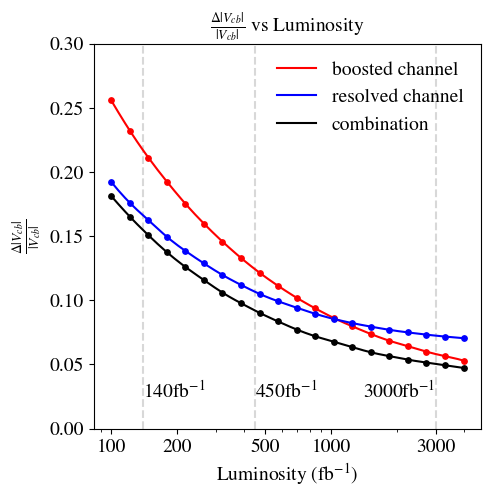

In [7]:
### extract information first

import os
import re

# use_helvet = False  ## true: use helvetica for plots, make sure the system have the font installed
# if use_helvet:
#     CMShelvet = hep.style.CMS
#     CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
#     plt.style.use(CMShelvet)
# else:
#     plt.style.use(hep.style.CMS)
    
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec

mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

start, end = 100, 4000
log_start, log_end = np.log10(start), np.log10(end)
log_points = np.linspace(log_start, log_end, 20)
points = np.power(10, log_points)

plt.figure(figsize=(5, 5))
    
# first do boosted
folder_path = "/home/pku/zhaoyz/pheno/notebooks_v2/datacards/boosted"  
errors = []

for i in range(20):
    lumi = points[i]
    folder_path_i = f"{folder_path}/strength_1_no_{i}"
    filename = "TotalUnc.txt"
    file_path = os.path.join(folder_path_i, filename)
    with open(file_path, "r") as file:
        content = file.read()
        match = re.search(r"r\s*:\s*[\+\-]?\d*\.\d+\s*-?([\d\.\+\-]+)\/\+?([\d\.\+\-]+)", content)
        if match:
            down_error = float(match.group(1))
            up_error = float(match.group(2))
            average_error = (abs(down_error) + abs(up_error)) / 2
            errors.append((lumi, average_error/2))

x_values, y_values = zip(*errors)
f = interp1d(x_values, y_values, kind='cubic')
x_new = np.linspace(100, 4000, 500)
y_new = f(x_new)
plt.scatter(x_values, y_values, color='red', zorder=5, s = 15)
plt.plot(x_new, y_new, color='red', linestyle='-', label=r'boosted channel', zorder=3)

print("Done boosted strength 1")


  
# then do resolved
folder_path = "/home/pku/zhaoyz/pheno/notebooks_v2/datacards/resolved"  
errors = []

for i in range(20):
    lumi = points[i]
    folder_path_i = f"{folder_path}/strength_1_no_{i}"
    filename = "TotalUnc.txt"
    file_path = os.path.join(folder_path_i, filename)
    with open(file_path, "r") as file:
        content = file.read()
        match = re.search(r"r\s*:\s*[\+\-]?\d*\.\d+\s*-?([\d\.\+\-]+)\/\+?([\d\.\+\-]+)", content)
        if match:
            down_error = float(match.group(1))
            up_error = float(match.group(2))
            average_error = (abs(down_error) + abs(up_error)) / 2
            errors.append((lumi, average_error/2))

x_values, y_values = zip(*errors)
f = interp1d(x_values, y_values, kind='cubic')
x_new = np.linspace(100, 4000, 500)
y_new = f(x_new)
plt.scatter(x_values, y_values, color='blue',  zorder=5, s = 15)
plt.plot(x_new, y_new, color='blue', linestyle='-', label=r'resolved channel', zorder=3)



# then do combined
folder_path = "/home/pku/zhaoyz/pheno/notebooks_v2/datacards/combined/combined"  
errors = []

for i in range(20):
    lumi = points[i]
    folder_path_i = f"{folder_path}/strength_1_no_{i}"
    filename = "TotalUnc.txt"
    file_path = os.path.join(folder_path_i, filename)
    with open(file_path, "r") as file:
        content = file.read()
        match = re.search(r"r\s*:\s*[\+\-]?\d*\.\d+\s*-?([\d\.\+\-]+)\/\+?([\d\.\+\-]+)", content)
        if match:
            down_error = float(match.group(1))
            up_error = float(match.group(2))
            average_error = (abs(down_error) + abs(up_error)) / 2
            errors.append((lumi, average_error/2))

x_values, y_values = zip(*errors)
f = interp1d(x_values, y_values, kind='cubic')
x_new = np.linspace(100, 4000, 500)
y_new = f(x_new)
plt.scatter(x_values, y_values, color='black',  zorder=5, s = 15)
plt.plot(x_new, y_new, color='black', linestyle='-', label=r'combination', zorder=3)



# plot settings

plt.ylim(0, 0.3)
# plt.xlim(0, 0.6)
plt.xscale('log')
plt.legend(loc = "upper right", fontsize = 14, frameon = False, ncol = 1)

plt.tick_params(axis='x', labelsize=14)  # x轴刻度字体大小
plt.tick_params(axis='y', labelsize=14)  # y轴刻度字体大小

plt.xticks([100, 200, 500, 1000, 3000 ],[100, 200, 500, 1000, 3000])

plt.axvline(x=140, color='grey', linestyle='--', alpha=0.3,label='Lumi.=140')
plt.axvline(x=450, color='grey', linestyle='--', alpha=0.3,label='Lumi.=450')
plt.axvline(x=3000, color='grey', linestyle='--', alpha=0.3,label='Lumi.=3000')

plt.text(140, 0.03, r"140$\mathrm{fb^{-1}}$", verticalalignment='center', horizontalalignment='left',fontsize = 14)
plt.text(450, 0.03, r"450$\mathrm{fb^{-1}}$", verticalalignment='center', horizontalalignment='left',fontsize = 14)
plt.text(1400, 0.03, r"3000$\mathrm{fb^{-1}}$", verticalalignment='center', horizontalalignment='left',fontsize = 14)

plt.xlabel(r"Luminosity ($\mathrm{fb^{-1}}$)", fontsize = 14)
plt.ylabel(r"$\frac{\Delta |V_{cb}|}{|V_{cb}|}$",fontsize = 14)
plt.title(r"$\frac{\Delta|V_{cb}|}{|V_{cb}|}$ vs Luminosity",fontsize = 14)

# 显示图形
plt.savefig(f"{plot_dir}/results_all_up_strength1.pdf",bbox_inches='tight')
plt.show()


Done boosted strength 1


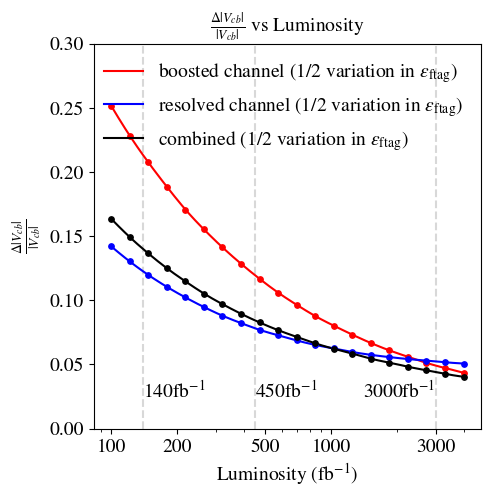

In [14]:
### extract information first

import os
import re

# use_helvet = False  ## true: use helvetica for plots, make sure the system have the font installed
# if use_helvet:
#     CMShelvet = hep.style.CMS
#     CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
#     plt.style.use(CMShelvet)
# else:
#     plt.style.use(hep.style.CMS)
    
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec

mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

start, end = 100, 4000
log_start, log_end = np.log10(start), np.log10(end)
log_points = np.linspace(log_start, log_end, 20)
points = np.power(10, log_points)

plt.figure(figsize=(5, 5))
    
# first do boosted
folder_path = "/home/pku/zhaoyz/pheno/notebooks_v2/datacards/boosted"  
errors = []

# for i in range(20):
#     lumi = points[i]
#     folder_path_i = f"{folder_path}/strength_1_no_{i}"
#     filename = "TotalUnc.txt"
#     file_path = os.path.join(folder_path_i, filename)
#     with open(file_path, "r") as file:
#         content = file.read()
#         match = re.search(r"r\s*:\s*[\+\-]?\d*\.\d+\s*-?([\d\.\+\-]+)\/\+?([\d\.\+\-]+)", content)
#         if match:
#             down_error = float(match.group(1))
#             up_error = float(match.group(2))
#             average_error = (abs(down_error) + abs(up_error)) / 2
#             errors.append((lumi, average_error/2))

# x_values, y_values = zip(*errors)
# f = interp1d(x_values, y_values, kind='cubic')
# x_new = np.linspace(100, 4000, 500)
# y_new = f(x_new)
# plt.scatter(x_values, y_values, color='red', zorder=5)
# plt.plot(x_new, y_new, color='red', linestyle='-', label=r'boosted channel (nominal variation in $ε_{\mathrm{ftag}}$)', zorder=3)

# print("Done boosted strength 1")



errors = []
for i in range(20):
    lumi = points[i]
    folder_path_i = f"{folder_path}/strength_0p5_no_{i}"
    filename = "TotalUnc.txt"
    file_path = os.path.join(folder_path_i, filename)
    with open(file_path, "r") as file:
        content = file.read()
        match = re.search(r"r\s*:\s*[\+\-]?\d*\.\d+\s*-?([\d\.\+\-]+)\/\+?([\d\.\+\-]+)", content)
        if match:
            down_error = float(match.group(1))
            up_error = float(match.group(2))
            average_error = (abs(down_error) + abs(up_error)) / 2
            errors.append((lumi, average_error/2))

x_values, y_values = zip(*errors)
f = interp1d(x_values, y_values, kind='cubic')
x_new = np.linspace(100, 4000, 500)
y_new = f(x_new)
plt.scatter(x_values, y_values, color='red', zorder=5, s=15)
plt.plot(x_new, y_new, color='red', linestyle='-', label=r'boosted channel (1/2 variation in $ε_{\mathrm{ftag}}$)', zorder=3)

print("Done boosted strength 1")
  
# then do resolved
folder_path = "/home/pku/zhaoyz/pheno/notebooks_v2/datacards/resolved"  

# then do resolved
# errors = []

# for i in range(20):
#     lumi = points[i]
#     folder_path_i = f"{folder_path}/strength_1_no_{i}"
#     filename = "TotalUnc.txt"
#     file_path = os.path.join(folder_path_i, filename)
#     with open(file_path, "r") as file:
#         content = file.read()
#         match = re.search(r"r\s*:\s*[\+\-]?\d*\.\d+\s*-?([\d\.\+\-]+)\/\+?([\d\.\+\-]+)", content)
#         if match:
#             down_error = float(match.group(1))
#             up_error = float(match.group(2))
#             average_error = (abs(down_error) + abs(up_error)) / 2
#             errors.append((lumi, average_error/2))

# x_values, y_values = zip(*errors)
# f = interp1d(x_values, y_values, kind='cubic')
# x_new = np.linspace(100, 4000, 500)
# y_new = f(x_new)
# plt.scatter(x_values, y_values, color='blue',  zorder=5)
# plt.plot(x_new, y_new, color='blue', linestyle='-', label=r'resolved channel (nominal variation in $ε_{\mathrm{ftag}}$)', zorder=3)



errors = []
for i in range(20):
    lumi = points[i]
    folder_path_i = f"{folder_path}/strength_0p5_no_{i}"
    filename = "TotalUnc.txt"
    file_path = os.path.join(folder_path_i, filename)
    with open(file_path, "r") as file:
        content = file.read()
        match = re.search(r"r\s*:\s*[\+\-]?\d*\.\d+\s*-?([\d\.\+\-]+)\/\+?([\d\.\+\-]+)", content)
        if match:
            down_error = float(match.group(1))
            up_error = float(match.group(2))
            average_error = (abs(down_error) + abs(up_error)) / 2
            errors.append((lumi, average_error/2))

x_values, y_values = zip(*errors)
f = interp1d(x_values, y_values, kind='cubic')
x_new = np.linspace(100, 4000, 500)
y_new = f(x_new)
plt.scatter(x_values, y_values, color='blue',  zorder=5, s= 15)
plt.plot(x_new, y_new, color='blue', linestyle='-', label=r'resolved channel (1/2 variation in $ε_{\mathrm{ftag}}$)', zorder=3)


# then do combined
folder_path = "/home/pku/zhaoyz/pheno/notebooks_v2/datacards/combined/combined"  
errors = []

# for i in range(20):
#     lumi = points[i]
#     folder_path_i = f"{folder_path}/strength_1_no_{i}"
#     filename = "TotalUnc.txt"
#     file_path = os.path.join(folder_path_i, filename)
#     with open(file_path, "r") as file:
#         content = file.read()
#         match = re.search(r"r\s*:\s*[\+\-]?\d*\.\d+\s*-?([\d\.\+\-]+)\/\+?([\d\.\+\-]+)", content)
#         if match:
#             down_error = float(match.group(1))
#             up_error = float(match.group(2))
#             average_error = (abs(down_error) + abs(up_error)) / 2
#             errors.append((lumi, average_error/2))

# x_values, y_values = zip(*errors)
# f = interp1d(x_values, y_values, kind='cubic')
# x_new = np.linspace(100, 4000, 500)
# y_new = f(x_new)
# plt.scatter(x_values, y_values, color='black',  zorder=5)
# plt.plot(x_new, y_new, color='black', linestyle='-', label=r'combination (nonimal variation in $ε_{\mathrm{ftag}}$)', zorder=3)



errors = []
for i in range(20):
    lumi = points[i]
    folder_path_i = f"{folder_path}/strength_0p5_no_{i}"
    filename = "TotalUnc.txt"
    file_path = os.path.join(folder_path_i, filename)
    with open(file_path, "r") as file:
        content = file.read()
        match = re.search(r"r\s*:\s*[\+\-]?\d*\.\d+\s*-?([\d\.\+\-]+)\/\+?([\d\.\+\-]+)", content)
        if match:
            down_error = float(match.group(1))
            up_error = float(match.group(2))
            average_error = (abs(down_error) + abs(up_error)) / 2
            errors.append((lumi, average_error/2))

x_values, y_values = zip(*errors)
f = interp1d(x_values, y_values, kind='cubic')
x_new = np.linspace(100, 4000, 500)
y_new = f(x_new)
plt.scatter(x_values, y_values, color='black',  zorder=5, s=15)
plt.plot(x_new, y_new, color='black', linestyle='-', label=r'combined (1/2 variation in $ε_{\mathrm{ftag}}$)', zorder=3)


# plot settings

plt.ylim(0, 0.3)
# plt.xlim(0, 0.6)
plt.xscale('log')
plt.legend(loc = "upper right", fontsize = 14, frameon = False, ncol = 1)

plt.tick_params(axis='x', labelsize=14)  # x轴刻度字体大小
plt.tick_params(axis='y', labelsize=14)  # y轴刻度字体大小

plt.xticks([100, 200, 500, 1000, 3000 ],[100, 200, 500, 1000, 3000])

plt.axvline(x=140, color='grey', linestyle='--', alpha=0.3,label='Lumi.=140')
plt.axvline(x=450, color='grey', linestyle='--', alpha=0.3,label='Lumi.=450')
plt.axvline(x=3000, color='grey', linestyle='--', alpha=0.3,label='Lumi.=3000')

plt.text(140, 0.03, r"140$\mathrm{fb^{-1}}$", verticalalignment='center', horizontalalignment='left',fontsize = 14)
plt.text(450, 0.03, r"450$\mathrm{fb^{-1}}$", verticalalignment='center', horizontalalignment='left',fontsize = 14)
plt.text(1400, 0.03, r"3000$\mathrm{fb^{-1}}$", verticalalignment='center', horizontalalignment='left',fontsize = 14)

plt.xlabel(r"Luminosity ($\mathrm{fb^{-1}}$)", fontsize = 14)
plt.ylabel(r"$\frac{\Delta |V_{cb}|}{|V_{cb}|}$",fontsize = 14)
plt.title(r"$\frac{\Delta|V_{cb}|}{|V_{cb}|}$ vs Luminosity",fontsize = 14)

# 显示图形
plt.savefig(f"{plot_dir}/results_only_variation.pdf",bbox_inches='tight')
plt.show()


### Split unc

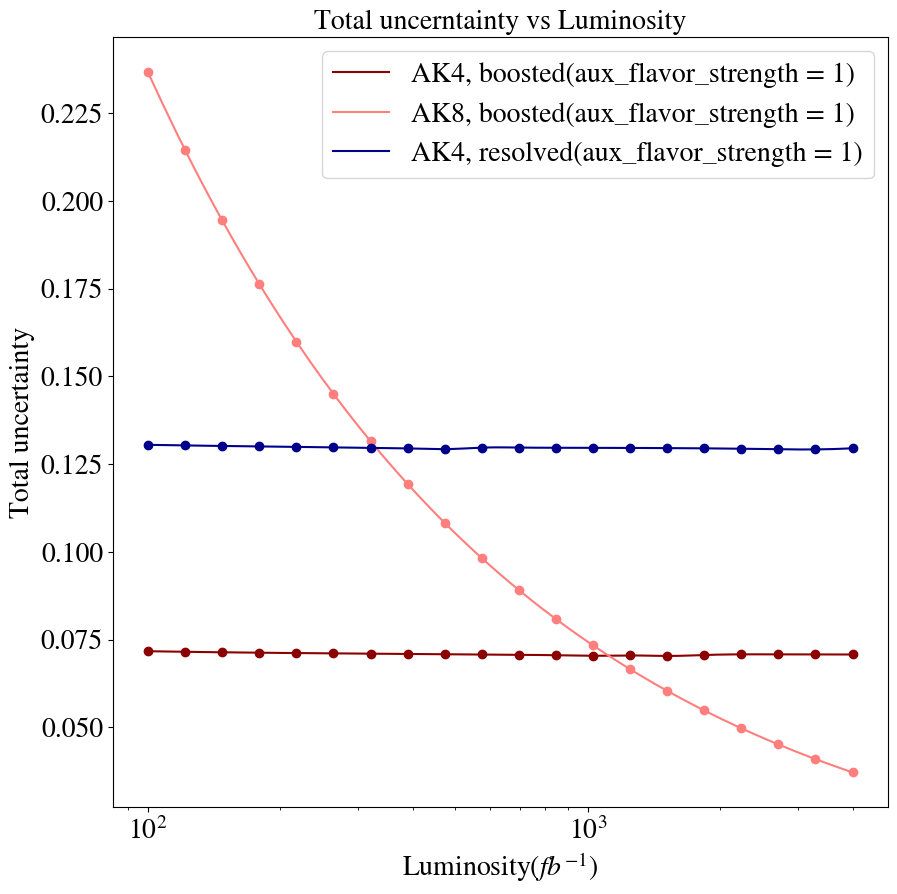

In [9]:
### extract information first

import os
import re

# use_helvet = False  ## true: use helvetica for plots, make sure the system have the font installed
# if use_helvet:
#     CMShelvet = hep.style.CMS
#     CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
#     plt.style.use(CMShelvet)
# else:
#     plt.style.use(hep.style.CMS)
    
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec

mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

plt.figure(figsize=(10, 10))
    
# first do boosted
folder_path = "/home/pku/zhaoyz/pheno/notebooks_v2/datacards/boosted"  
ftag_averages = []
wcb_sf_averages = []

for i in range(20):
    lumi = points[i]
    folder_path_i = f"{folder_path}/strength_1_no_{i}"
    filename = "BreakDown.txt"
    file_path = os.path.join(folder_path_i, filename)
    with open(file_path, "r") as file:
        content = file.read()
        ftag_pattern = r"ftag:up:([\d\.\-]+), down: ([\d\.\-]+)"
        wcb_sf_pattern = r"wcb_sf:up:([\d\.\-]+), down: ([\d\.\-]+)"
        match = re.search(r"r\s*:\s*[\+\-]?\d*\.\d+\s*-?([\d\.\+\-]+)\/\+?([\d\.\+\-]+)", content)
        
        ftag_match = re.search(ftag_pattern, content)
        if ftag_match:
            ftag_up = float(ftag_match.group(1))
            ftag_down = float(ftag_match.group(2))
            ftag_avg = (abs(ftag_up) + abs(ftag_down)) / 2  # 计算平均值
            ftag_averages.append((lumi,ftag_avg))
        # 提取 wcb_sf 的 up 和 down 值
        wcb_sf_match = re.search(wcb_sf_pattern, content)
        if wcb_sf_match:
            wcb_sf_up = float(wcb_sf_match.group(1))
            wcb_sf_down = float(wcb_sf_match.group(2))
            wcb_sf_avg = (abs(wcb_sf_up) + abs(wcb_sf_down)) / 2  # 计算平均值
            wcb_sf_averages.append((lumi,wcb_sf_avg))

x_values1, y_values1 = zip(*ftag_averages)
x_values2, y_values2 = zip(*wcb_sf_averages)
plt.scatter(x_values1, y_values1, color='#8B0000', zorder=5)
plt.scatter(x_values2, y_values2, color='#FF7F7F', zorder=5)

f = interp1d(x_values1, y_values1, kind='cubic')
x_new = np.linspace(100, 4000, 500)
y_new = f(x_new)
plt.plot(x_new, y_new, color='#8B0000', linestyle='-', label='AK4, boosted(aux_flavor_strength = 1)', zorder=3)

f = interp1d(x_values2, y_values2, kind='cubic')
x_new = np.linspace(100, 4000, 500)
y_new = f(x_new)
plt.plot(x_new, y_new, color='#FF7F7F', linestyle='-', label='AK8, boosted(aux_flavor_strength = 1)', zorder=3)

# first do resolved
folder_path = "/home/pku/zhaoyz/pheno/notebooks_v2/datacards/resolved"  
ftag_averages = []

for i in range(20):
    lumi = points[i]
    folder_path_i = f"{folder_path}/strength_1_no_{i}"
    filename = "BreakDown.txt"
    file_path = os.path.join(folder_path_i, filename)
    with open(file_path, "r") as file:
        content = file.read()
        ftag_pattern = r"ftag:up:([\d\.\-]+), down: ([\d\.\-]+)"
        wcb_sf_pattern = r"wcb_sf:up:([\d\.\-]+), down: ([\d\.\-]+)"
        match = re.search(r"r\s*:\s*[\+\-]?\d*\.\d+\s*-?([\d\.\+\-]+)\/\+?([\d\.\+\-]+)", content)
        
        ftag_match = re.search(ftag_pattern, content)
        if ftag_match:
            ftag_up = float(ftag_match.group(1))
            ftag_down = float(ftag_match.group(2))
            ftag_avg = (abs(ftag_up) + abs(ftag_down)) / 2  # 计算平均值
            ftag_averages.append((lumi,ftag_avg))
        # 提取 wcb_sf 的 up 和 down 值

x_values1, y_values1 = zip(*ftag_averages)
plt.scatter(x_values1, y_values1, color='#00008B', zorder=5)

f = interp1d(x_values1, y_values1, kind='cubic')
x_new = np.linspace(100, 4000, 500)
y_new = f(x_new)
plt.plot(x_new, y_new, color='#00008B', linestyle='-', label='AK4, resolved(aux_flavor_strength = 1)', zorder=3)

# plot settings

plt.xscale('log')
plt.legend(fontsize = 20)

plt.tick_params(axis='x', labelsize=20)  # x轴刻度字体大小
plt.tick_params(axis='y', labelsize=20)  # y轴刻度字体大小

plt.xlabel(r"Luminosity($fb^{-1}$)", fontsize = 20)
plt.ylabel("Total uncertainty",fontsize = 20)
plt.title("Total uncerntainty vs Luminosity",fontsize = 20)

# 显示图形
plt.savefig(f"{plot_dir}/split.pdf",bbox_inches='tight')
plt.show()


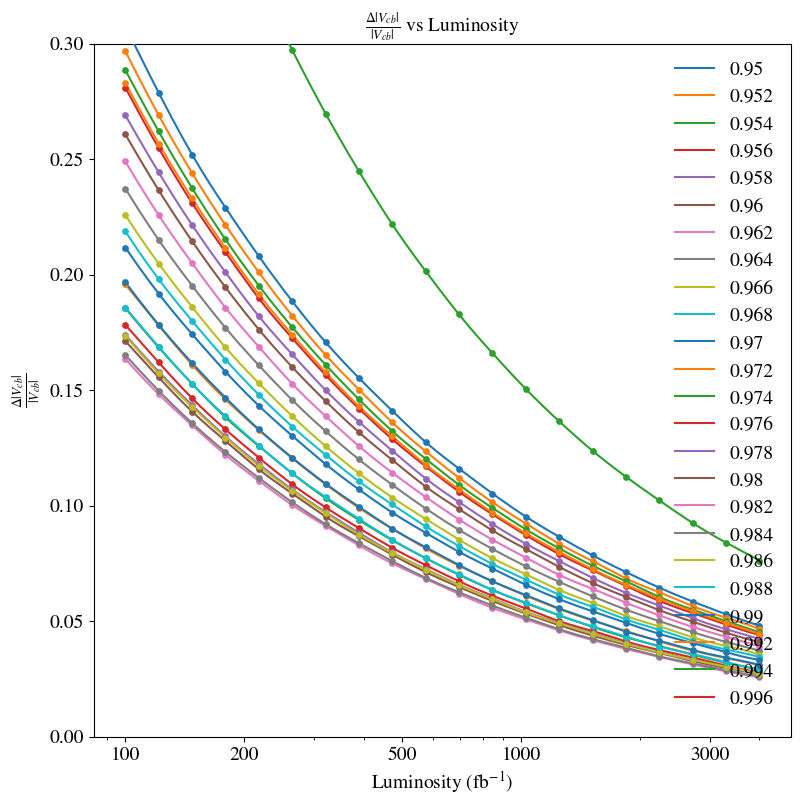

In [42]:
### extract information first

import os
import re

from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec

mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

start, end = 100, 4000
log_start, log_end = np.log10(start), np.log10(end)
log_points = np.linspace(log_start, log_end, 20)
points = np.power(10, log_points)

plt.figure(figsize=(9, 9))
    
# first do boosted
folder_path = "/home/pku/zhaoyz/pheno/notebooks_v2/datacards/new_senario/resolved"  
errors = []

strength_dict = {}

for thres_idx, thres in enumerate(list(np.arange(0.95,0.998,0.002))):
    strength_dict[thres_idx] = thres

for strength in range(24):
    errors = []
    for i in range(20):
        lumi = points[i]
        folder_path_i = f"{folder_path}/strength_point_{i}_{strength}"
        filename = "TotalUnc.txt"
        file_path = os.path.join(folder_path_i, filename)
        with open(file_path, "r") as file:
            content = file.read()
            match = re.search(r"r\s*:\s*[\+\-]?\d*\.\d+\s*-?([\d\.\+\-]+)\/\+?([\d\.\+\-]+)", content)
            if match:
                down_error = float(match.group(1))
                up_error = float(match.group(2))
                average_error = (abs(down_error) + abs(up_error)) / 2
                errors.append((lumi, average_error/2))

    x_values, y_values = zip(*errors)
    f = interp1d(x_values, y_values, kind='cubic')
    x_new = np.linspace(100, 4000, 500)
    y_new = f(x_new)
    plt.scatter(x_values, y_values, zorder=5, s = 15)
    plt.plot(x_new, y_new, linestyle='-', label=f"{strength_dict[strength]}", zorder=3)


# plot settings

plt.ylim(0, 0.3)
# plt.xlim(0, 0.6)
plt.xscale('log')
plt.legend(loc = "upper right", fontsize = 14, frameon = False)

plt.tick_params(axis='x', labelsize=14)  # x轴刻度字体大小
plt.tick_params(axis='y', labelsize=14)  # y轴刻度字体大小

plt.xticks([100, 200, 500, 1000, 3000 ],[100, 200, 500, 1000, 3000])

# plt.axvline(x=140, color='grey', linestyle='--', alpha=0.3,label='Lumi.=140')
# plt.axvline(x=450, color='grey', linestyle='--', alpha=0.3,label='Lumi.=450')
# plt.axvline(x=3000, color='grey', linestyle='--', alpha=0.3,label='Lumi.=3000')

# plt.text(140, 0.03, r"140$\mathrm{fb^{-1}}$", verticalalignment='center', horizontalalignment='left',fontsize = 14)
# plt.text(450, 0.03, r"450$\mathrm{fb^{-1}}$", verticalalignment='center', horizontalalignment='left',fontsize = 14)
# plt.text(1400, 0.03, r"3000$\mathrm{fb^{-1}}$", verticalalignment='center', horizontalalignment='left',fontsize = 14)

plt.xlabel(r"Luminosity ($\mathrm{fb^{-1}}$)", fontsize = 14)
plt.ylabel(r"$\frac{\Delta |V_{cb}|}{|V_{cb}|}$",fontsize = 14)
plt.title(r"$\frac{\Delta|V_{cb}|}{|V_{cb}|}$ vs Luminosity",fontsize = 14)

# 显示图形
plt.savefig(f"{plot_dir}/results_envelope_resolved.pdf",bbox_inches='tight')
plt.show()
